<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '' 

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)





**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [8]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
def get_score(clf):
    cv_score=cross_val_score(clf,X_train,y_train,cv=skf).mean()
    clf.fit(X_train,y_train)
    holdout_score=clf.score(X_valid,y_valid)
    return cv_score,holdout_score

In [146]:
knn=KNeighborsClassifier(n_jobs=-1,n_neighbors=100)
get_score(knn)

(0.56167298405556676, 0.58402465039108797)

**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [147]:
write_answer_to_file(str(round(cv_score,3))+" "+str(round(holdout_score,3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
forest = RandomForestClassifier(n_estimators=100,random_state=17,oob_score=True,n_jobs=-1)
forest.fit(X_train,y_train)
oob_score=forest.oob_score_
holdout_score=forest.score(X_valid,y_valid)
oob_score,holdout_score

(0.72028043080674664, 0.73003081298885997)

**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [15]:
write_answer_to_file(str(round(oob_score,3))+" "+str(round(holdout_score,3)),
                     'answer4_2.txt')

In [16]:
!cat answer4_2.txt

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [17]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [18]:
logit = LogisticRegression(random_state=17)
get_score(logit)

(0.76254867130480253, 0.78170182507703245)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [19]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,cv=skf,n_jobs=-1,multi_class='multinomial',random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 16.3 s


In [244]:
def score_to_array(score):
    dictlist = list()
    for key, value in score.items():
        temp = [value]
        dictlist.append(temp)
    res=np.array([])
    for i in dictlist:
        item=np.mean(np.array(i),axis=1)
        res=np.append(res,item)
    res=res.reshape([10,10])
    res=np.mean(res,axis=1)
    return res

In [254]:
scores=pd.DataFrame(columns=[i for i in range(10)])
scores
for i in logit_grid_searcher1.scores_.values():
    scores.loc[len(scores)]=i[0]
    scores.loc[len(scores)]=i[1]
    scores.loc[len(scores)]=i[2]
scores_by_c=scores.mean()

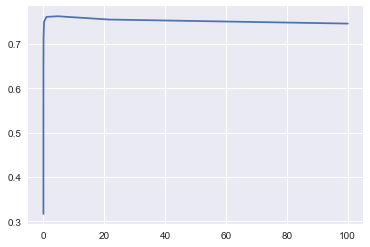

In [255]:
score=score_to_array(logit_grid_searcher1.scores_)
plt.plot(logit_c_values1,scores_by_c)
plt.show()

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [256]:
scores_by_c

0    0.316799
1    0.473586
2    0.554767
3    0.648551
4    0.715507
5    0.750054
6    0.761025
7    0.762447
8    0.755029
9    0.745886
dtype: float64

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [21]:
logit_grid_searcher1.Cs_[scores.mean().argmax()],scores.mean().max()

(4.6415888336127722, 0.76244679760874845)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

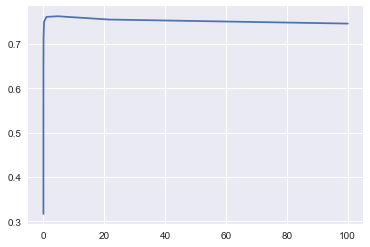

In [22]:
plt.plot(logit_c_values1, scores.mean());

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [23]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 =  LogisticRegressionCV(Cs=logit_c_values2,cv=skf,n_jobs=-1,multi_class='multinomial',random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 46.7 s


In [73]:
logit_grid_searcher2.scores_

{31: array([[ 0.76438356,  0.76438356,  0.76407915,  0.76468798,  0.76499239,
          0.76377473,  0.76468798,  0.76407915,  0.76407915,  0.76347032,
          0.76316591,  0.76133942,  0.76103501,  0.76073059,  0.76012177,
          0.75920852,  0.76012177,  0.75981735,  0.76042618,  0.76012177],
        [ 0.75846295,  0.76120769,  0.76151266,  0.76151266,  0.76120769,
          0.76120769,  0.76120769,  0.76151266,  0.7621226 ,  0.76242757,
          0.76242757,  0.76242757,  0.76181763,  0.76181763,  0.76120769,
          0.76090271,  0.76090271,  0.76090271,  0.76059774,  0.76059774],
        [ 0.76540574,  0.76296522,  0.76388041,  0.76296522,  0.76296522,
          0.76266016,  0.76266016,  0.76266016,  0.76357535,  0.76296522,
          0.76235509,  0.76174497,  0.76174497,  0.76174497,  0.76174497,
          0.76082977,  0.76021965,  0.75960952,  0.75960952,  0.75930445]]),
 33: array([[ 0.76438356,  0.76438356,  0.76407915,  0.76468798,  0.76499239,
          0.76377473,  0.

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
scores=pd.DataFrame(columns=[i for i in range(len(logit_c_values2))])
scores
for i in logit_grid_searcher2.scores_.values():
    scores.loc[len(scores)]=i[0]
    scores.loc[len(scores)]=i[1]
    scores.loc[len(scores)]=i[2]
logit_mean_cv_scores2=scores.mean()
logit_mean_cv_scores2

0     0.762751
1     0.762852
2     0.763157
3     0.763055
4     0.763055
5     0.762548
6     0.762852
7     0.762751
8     0.763259
9     0.762954
10    0.762650
11    0.761837
12    0.761533
13    0.761431
14    0.761025
15    0.760314
16    0.760415
17    0.760110
18    0.760211
19    0.760008
dtype: float64

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()],logit_mean_cv_scores2.max()

(4.6842105263157894, 0.76325903227254022)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

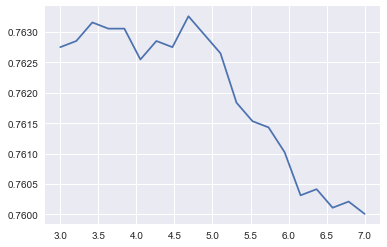

In [31]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [261]:
logit.score(X_valid, y_valid)

0.78170182507703245

In [33]:
cv_score,holdout_score=get_score(logit)

**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [34]:
write_answer_to_file(str(round(cv_score,3))+" "+str(round(holdout_score,3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [35]:
from sklearn.svm import LinearSVC

In [36]:
svm = LinearSVC(C=1,random_state=17)
get_score(svm)

(0.75655369169304965, 0.77696136525242954)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [37]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV (svm,svm_params1,cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 59.3 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
svm_grid_searcher1.best_params_,svm_grid_searcher1.best_score_

({'C': 1111.1112000000001}, 0.68908758382442592)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

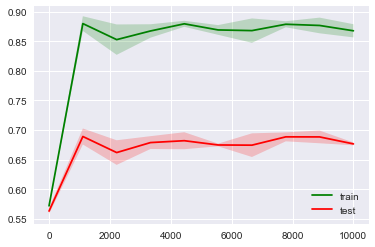

In [39]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [40]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV (svm,svm_params2,cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 45s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [41]:
svm_grid_searcher2.best_params_,svm_grid_searcher2.best_score_

({'C': 0.24213793103448275}, 0.76498679130258074)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

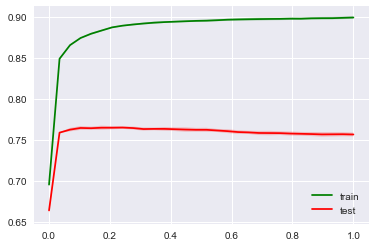

In [42]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [43]:
y_pred=svm_grid_searcher2.predict(X_valid)
svm_cv_acc = accuracy_score(y_valid,y_pred)
svm_cv_acc

0.78359800900687371

In [44]:
cv_score,holdout_score=get_score(svm_grid_searcher2)

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [45]:
write_answer_to_file(str(round(cv_score,3))+" "+str(round(holdout_score,3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [46]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y_users = pickle.load(y_pkl)
    lab_enc = preprocessing.LabelEncoder()
    y_users = lab_enc.fit_transform(y_users)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y_users, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y_users)
    y_users=list(map(int,y_users))
    cv_score=cross_val_score(estimator,X_train,y_train,cv=cv).mean()
    estimator.fit(X_train,y_train)
    holdout_score=estimator.score(X_valid,y_valid)
    return cv_score,holdout_score

**Убедитесь, что функция работает.**

In [47]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76498658317429324, 0.78359800900687371)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [48]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 'X_sparse_10users_s15_w10.pkl',
        'y_10users_s15_w10.pkl', skf, random_state=17, test_size=0.3)

(0.82412334030111822, 0.84166864185826029)

In [49]:
%%time
estimator = svm_grid_searcher2.best_estimator_
num_users=10
#for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
for window_size, session_length in [[5,5],[5,7],[7,7],[5,10],[7,10],[5,15],[7,15],[10,15]]:
    if window_size <= session_length:
        path_to_X_pkl = 'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
        path_to_y_pkl = 'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
        print (window_size, session_length,model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3))

5 5 (0.72457100088188031, 0.73779042200094835)
5 7 (0.77304177154740927, 0.78828828828828834)
7 7 (0.75156145420704468, 0.76339804214368678)
5 10 (0.81836230505824814, 0.8285917496443812)
7 10 (0.79992559213440051, 0.80736684917869583)
5 15 (0.87160977062948997, 0.87731152204836416)
7 15 (0.8504951547307148, 0.85564957690393229)
10 15 (0.82412334030111822, 0.84166864185826029)
Wall time: 53.5 s


**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [50]:
s1,s2=model_assessment(svm_grid_searcher2.best_estimator_, 
                 'X_sparse_10users_s15_w5.pkl',
        'y_10users_s15_w5.pkl', skf, random_state=17, test_size=0.3)

In [51]:
write_answer_to_file(str(round(s1,3))+" "+str(round(s2,3)),
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [200]:
%%time
estimator = svm_grid_searcher2.best_estimator_
num_users=150
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = 'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
    path_to_y_pkl = 'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'
    print     (window_size, session_length,model_assessment(estimator, path_to_X_pkl,path_to_y_pkl, skf, random_state=17, test_size=0.3))

5 5 (0.40982610251362867, 0.4236749890494963)
7 7 (0.43749537278498768, 0.45488299213134858)


FileNotFoundError: [Errno 2] No such file or directory: 'X_sparse_150users_s10_w10.pkl'

**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [201]:
s1,s2=model_assessment(svm_grid_searcher2.best_estimator_, 
                 'X_sparse_150users.pkl',
        'y_150users.pkl', skf, random_state=17, test_size=0.3)

In [202]:
write_answer_to_file(str(round(s1,3))+" "+str(round(s2,3)),
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [52]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [53]:
lab_enc = preprocessing.LabelEncoder()
y_150users = lab_enc.fit_transform(y_150users)

In [54]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)


**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [64]:
Cs_best

4.6842105263157894

In [263]:
logit_cv_150users

LogisticRegressionCV(Cs=[4.6842105263157894], class_weight=None, cv=None,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=17, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [264]:
#%%time
Cs_best=logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]
Cs_best
print (Cs_best)
logit_cv_150users = LogisticRegressionCV(Cs=[4.68421],random_state=17,n_jobs=-1,multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)


4.68421052632


LogisticRegressionCV(Cs=[4.68421], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [265]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id]=logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id,logit_cv_150users.scores_[user_id].mean()))

User 0, CV score: 0.9960272433769436
User 1, CV score: 0.9963510246346834
User 2, CV score: 0.995266599486151
User 3, CV score: 0.9916592959110311
User 4, CV score: 0.9903242129868092
User 5, CV score: 0.9941301309856043
User 6, CV score: 0.9936609317575155
User 7, CV score: 0.9859872300654415
User 8, CV score: 0.9979772190075838
User 9, CV score: 0.9952357772986161
User 10, CV score: 0.9943388864456445
User 11, CV score: 0.9935150944004606
User 12, CV score: 0.996767963083293
User 13, CV score: 0.9947765399257253
User 14, CV score: 0.9963194919846642
User 15, CV score: 0.9962885385423458
User 16, CV score: 0.9904706276553775
User 17, CV score: 0.9943594697482854
User 18, CV score: 0.9945054954925464
User 19, CV score: 0.9912734542098433
User 20, CV score: 0.9809621804598384
User 21, CV score: 0.9969035373552387
User 22, CV score: 0.9947238892738456
User 23, CV score: 0.990960670225865
User 24, CV score: 0.9966220220895724
User 25, CV score: 0.9943074588544315
User 26, CV score: 0.9950

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [266]:
class_distr = np.bincount(y_train_150.astype('int'))
total=class_distr.sum()
acc_diff_vs_constant=list()
for user_id in np.unique(y_train_150):
    dol1=cv_scores_by_user[user_id]
    dol2=(total-class_distr[user_id])/total
    acc_diff_vs_constant.append(dol1-dol2)
acc_diff_vs_constant=pd.Series(acc_diff_vs_constant)    

In [267]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values)) > 0).sum()
num_better_than_default=round(num_better_than_default/150,3)
num_better_than_default

0.78700000000000003

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [124]:
write_answer_to_file(num_better_than_default, 
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [141]:
y_train_150

array([125, 102,  42, ...,  18,   0,  34], dtype=int64)

In [142]:
y_binary_128 = (y_train_150==128)*1

In [138]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');
    plt.show()

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [144]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator,X_train_150, y_binary_128,train_sizes=train_sizes, cv=skf)

Wall time: 15.8 s


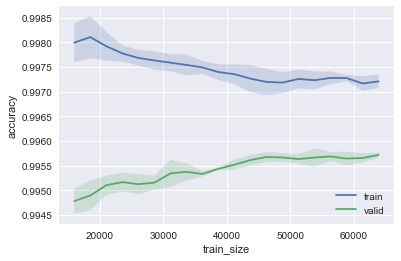

In [145]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/identify-me-if-you-can4) Kaggle Inclass.